# Recreation of UNet
It is only for learning purposes: for CNNs and for Pytorch.

In [1]:
import os
import random
from PIL import Image
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.amp import autocast, GradScaler

print(torch.__version__)          # should show 2.8.0+cu126
print(torch.version.cuda)         # should show '12.6'
print(torch.cuda.is_available())  # should be True
print(torch.cuda.get_device_name(0))  # NVIDIA RTX A6000

2.8.0+cu126
12.6
True
NVIDIA RTX A6000


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers = 1

if device == "cuda":
    print("Using GPU")
    num_workers = torch.cuda.device_count() * 4
else:
    print("Using CPU")

generator = torch.Generator().manual_seed(25)

Using GPU


In [3]:
DATA_DIR = "data/"
DATASET_DIR = DATA_DIR + "eye/"
TRAIN_DIR = DATASET_DIR + "train/"
TRAIN_MASKS_DIR = DATASET_DIR + "train_masks/"
LIMIT = 603

STATES_DIR = "states/"
MODEL_PATH = STATES_DIR + "eye_2.pth"
IMAGE_SIZE = 1024

In [4]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 8
EPOCHS = 30

## UNet classes (parts)
### Structure elements

In [5]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channel):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channel, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [6]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channel):
        super(DownSample, self).__init__()
        self.conv = Block(in_channels, out_channel)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        """
        :return: the tensor before pooling (tensor to be copied) and the tensor after pooling (result)
        """
        y = self.conv(x)
        p = self.pool(y)
        return y, p

In [7]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channel):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = Block(in_channels, out_channel)

    def forward(self, x1, x2):
        """
        :param x1: the copied tensor from the downsampling
        :param x2: the tensor from the previous layer
        """
        x2 = self.up(x2)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.down_conv1 = DownSample(in_channels, 64)
        self.down_conv2 = DownSample(64, 128)
        self.down_conv3 = DownSample(128, 256)
        self.down_conv4 = DownSample(256, 512)

        self.bottle_neck = Block(512, 1024)

        self.up_conv1 = UpSample(1024, 512)
        self.up_conv2 = UpSample(512, 256)
        self.up_conv3 = UpSample(256, 128)
        self.up_conv4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        # the s params are the saved tensors that will be concatenated at the upsampling stage
        s1, down1 = self.down_conv1(x)
        s2, down2 = self.down_conv2(down1)
        s3, down3 = self.down_conv3(down2)
        s4, down4 = self.down_conv4(down3)

        b = self.bottle_neck(down4)

        up1 = self.up_conv1(s4, b)
        up2 = self.up_conv2(s3, up1)
        up3 = self.up_conv3(s2, up2)
        up4 = self.up_conv4(s1, up3)

        return self.out(up4)

## Dataset
Using Carvana dataset for testing (https://www.kaggle.com/c/carvana-image-masking-challenge)

### Get data

In [5]:
class GetDataset(Dataset):
    def __init__(self, root_path, limit=None):
        self.root_path = root_path
        self.limit = limit
        self.images = sorted([root_path + "train/" + i for i in os.listdir(root_path + "train/")])[:self.limit]
        self.masks = sorted([root_path + "train_masks/" + i for i in os.listdir(root_path + "train_masks/")])[:self.limit]

        self.image_transform = transforms.Compose([
            transforms.Pad(padding=(0, 0, 1, 1)),  # left, top, right, bottom
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
        ])

        self.mask_transform = transforms.Compose([
            transforms.Pad(padding=(0, 0, 1, 1)),  # left, top, right, bottom
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor()
        ])

        if self.limit is None:
            self.limit = len(self.images)

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("L")
        mask = Image.open(self.masks[index]).convert("L")

        # Apply transforms
        img = self.image_transform(img)
        mask = self.mask_transform(mask)

        # Convert mask to binary: 0 or 1
        mask = (mask > 0).float()

        return img, mask, self.images[index]

    def __len__(self):
        return min(len(self.images), self.limit)

In [6]:
train_dataset = GetDataset(DATASET_DIR, LIMIT)

In [7]:
first = train_dataset.__getitem__(0)
print(first)

(tensor([[[0.2627, 0.2549, 0.2471,  ..., 0.2392, 0.2471, 0.0000],
         [0.2588, 0.2510, 0.2471,  ..., 0.2431, 0.2510, 0.0000],
         [0.2510, 0.2510, 0.2471,  ..., 0.2471, 0.2510, 0.0000],
         ...,
         [0.2431, 0.2471, 0.2510,  ..., 0.2471, 0.2431, 0.0000],
         [0.2471, 0.2471, 0.2510,  ..., 0.2471, 0.2431, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'data/eye/train/0001.png')


### Split and load it

In [7]:
# split dataset in train, test and validation batch (80% train, 10% test, 10% validation)
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)
test_dataset, val_dataset = random_split(test_dataset, [0.5, 0.5], generator=generator)

In [8]:
# num_workers is set to 0 here because notebook cannot load data in multithreading
train_dataloader = DataLoader(dataset=train_dataset,
                              num_workers=0, pin_memory=False,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            num_workers=0, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                            num_workers=0, pin_memory=False,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

## Learning

In [14]:
model = UNet(in_channels=1, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
#criterion = nn.BCEWithLogitsLoss()

In [9]:
def dice(prediction, target, threshold=0.5, epsilon=1e-7):
    """
    Compute Dice coefficient for binary masks.
    Works for both single images [1,H,W] or batches [B,1,H,W].

    Args:
        prediction: torch.Tensor, probabilities or logits
        target: torch.Tensor, same shape as prediction, binary mask (0 or 1)
        threshold: threshold to binarize predictions
        epsilon: small value to avoid division by zero

    Returns:
        Dice coefficient (scalar)
    """
    # Convert predictions to binary
    prediction = (prediction > threshold).float()
    target = target.float()

    if prediction.dim() == 4:  # batch mode: [B, 1, H, W]
        intersection = torch.sum(prediction * target, dim=(1, 2, 3))
        union = torch.sum(prediction, dim=(1, 2, 3)) + torch.sum(target, dim=(1, 2, 3))
        dice_score = (2 * intersection + epsilon) / (union + epsilon)
        return dice_score.mean()  # mean over batch
    elif prediction.dim() == 3:  # single image: [1,H,W]
        intersection = torch.sum(prediction * target)
        union = torch.sum(prediction) + torch.sum(target)
        return (2 * intersection + epsilon) / (union + epsilon)
    else:
        raise ValueError(f"Unexpected tensor shape {prediction.shape}. Expected [1,H,W] or [B,1,H,W].")

In [10]:
def dice_loss(pred, target, epsilon=1e-7):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    return 1 - ((2 * intersection + epsilon) / (union + epsilon)).mean()

pos_weight = torch.tensor([20.0]).to(device)  # more weight on foreground
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
def combined_loss(pred, target):
    bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([20.0]).to(device))(pred, target)
    pred_sig = torch.sigmoid(pred)
    intersection = (pred_sig * target).sum()
    dice_loss = 1 - (2 * intersection + 1e-7) / (pred_sig.sum() + target.sum() + 1e-7)
    return bce + dice_loss
def combined_loss_2(pred, target):
    bce = criterion(pred, target)
    return bce + dice_loss(pred, target)
    #return dice_loss(pred, target)

In [11]:
def free_cache():
    # release unused CUDA memory
    torch.cuda.empty_cache()

In [18]:
def train(save=True, path=MODEL_PATH):
    t_losses = []
    t_dcs = []
    v_losses = []
    v_dcs = []

    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_running_loss = 0
        train_running_dc = 0

        for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)      # [B,1,H,W]
            mask = img_mask[1].float().to(device)     # [B,1,H,W]

            optimizer.zero_grad()
            y_pred = model(img)

            # Combined BCE + Dice loss
            loss = combined_loss(y_pred, mask)
            loss.backward()
            optimizer.step()

            # Compute Dice for monitoring
            dc = dice(y_pred, mask)  # batch-aware Dice

            train_running_loss += loss.item()
            train_running_dc += dc.item()

        train_loss = train_running_loss / (idx + 1)
        train_dc = train_running_dc / (idx + 1)

        t_losses.append(train_loss)
        t_dcs.append(train_dc)

        # ------------------ Validation ------------------
        model.eval()
        val_running_loss = 0
        val_running_dc = 0

        with torch.no_grad():
            for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
                img = img_mask[0].float().to(device)
                mask = img_mask[1].float().to(device)

                y_pred = model(img)
                loss = combined_loss(y_pred, mask)
                dc = dice(y_pred, mask)

                val_running_loss += loss.item()
                val_running_dc += dc.item()

            val_loss = val_running_loss / (idx + 1)
            val_dc = val_running_dc / (idx + 1)

        v_losses.append(val_loss)
        v_dcs.append(val_dc)

        print("-" * 30)
        print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
        print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
        print("-" * 30)

    if save:
        torch.save(model.state_dict(), path)

    return t_losses, t_dcs, v_losses, v_dcs


In [20]:
free_cache()
train_losses, train_dcs, val_losses, val_dcs = train(True)
free_cache()

  3%|▎         | 1/30 [00:16<07:54, 16.36s/it]

------------------------------
Training Loss EPOCH 1: 2.2551
Training DICE EPOCH 1: 0.0590
Validation Loss EPOCH 1: 2.2218
Validation DICE EPOCH 1: 0.1392
------------------------------


  7%|▋         | 2/30 [00:30<07:07, 15.28s/it]

------------------------------
Training Loss EPOCH 2: 2.3068
Training DICE EPOCH 2: 0.1354
Validation Loss EPOCH 2: 2.1958
Validation DICE EPOCH 2: 0.1359
------------------------------


 10%|█         | 3/30 [00:45<06:44, 14.99s/it]

------------------------------
Training Loss EPOCH 3: 2.2321
Training DICE EPOCH 3: 0.1493
Validation Loss EPOCH 3: 2.2131
Validation DICE EPOCH 3: 0.1501
------------------------------


 13%|█▎        | 4/30 [01:00<06:26, 14.87s/it]

------------------------------
Training Loss EPOCH 4: 2.2364
Training DICE EPOCH 4: 0.1444
Validation Loss EPOCH 4: 2.2381
Validation DICE EPOCH 4: 0.1324
------------------------------


 17%|█▋        | 5/30 [01:15<06:11, 14.85s/it]

------------------------------
Training Loss EPOCH 5: 2.2260
Training DICE EPOCH 5: 0.1540
Validation Loss EPOCH 5: 2.1793
Validation DICE EPOCH 5: 0.1508
------------------------------


 20%|██        | 6/30 [01:29<05:55, 14.79s/it]

------------------------------
Training Loss EPOCH 6: 2.2200
Training DICE EPOCH 6: 0.1530
Validation Loss EPOCH 6: 2.1508
Validation DICE EPOCH 6: 0.1628
------------------------------


 23%|██▎       | 7/30 [01:44<05:41, 14.86s/it]

------------------------------
Training Loss EPOCH 7: 2.2191
Training DICE EPOCH 7: 0.1505
Validation Loss EPOCH 7: 2.1995
Validation DICE EPOCH 7: 0.1545
------------------------------


 27%|██▋       | 8/30 [01:59<05:27, 14.86s/it]

------------------------------
Training Loss EPOCH 8: 2.2161
Training DICE EPOCH 8: 0.1559
Validation Loss EPOCH 8: 2.1920
Validation DICE EPOCH 8: 0.1384
------------------------------


 30%|███       | 9/30 [02:14<05:11, 14.86s/it]

------------------------------
Training Loss EPOCH 9: 2.2168
Training DICE EPOCH 9: 0.1557
Validation Loss EPOCH 9: 2.1752
Validation DICE EPOCH 9: 0.1514
------------------------------


 33%|███▎      | 10/30 [02:29<04:56, 14.82s/it]

------------------------------
Training Loss EPOCH 10: 2.2072
Training DICE EPOCH 10: 0.1730
Validation Loss EPOCH 10: 2.2035
Validation DICE EPOCH 10: 0.1225
------------------------------


 37%|███▋      | 11/30 [02:43<04:41, 14.81s/it]

------------------------------
Training Loss EPOCH 11: 2.2285
Training DICE EPOCH 11: 0.1116
Validation Loss EPOCH 11: 2.2211
Validation DICE EPOCH 11: 0.1477
------------------------------


 40%|████      | 12/30 [02:58<04:27, 14.85s/it]

------------------------------
Training Loss EPOCH 12: 2.2287
Training DICE EPOCH 12: 0.1369
Validation Loss EPOCH 12: 2.1795
Validation DICE EPOCH 12: 0.1494
------------------------------


 43%|████▎     | 13/30 [03:13<04:12, 14.88s/it]

------------------------------
Training Loss EPOCH 13: 2.2241
Training DICE EPOCH 13: 0.1491
Validation Loss EPOCH 13: 2.2063
Validation DICE EPOCH 13: 0.1420
------------------------------


 47%|████▋     | 14/30 [03:28<03:59, 14.94s/it]

------------------------------
Training Loss EPOCH 14: 2.2229
Training DICE EPOCH 14: 0.1547
Validation Loss EPOCH 14: 2.1792
Validation DICE EPOCH 14: 0.1572
------------------------------


 50%|█████     | 15/30 [03:43<03:43, 14.89s/it]

------------------------------
Training Loss EPOCH 15: 2.2181
Training DICE EPOCH 15: 0.1503
Validation Loss EPOCH 15: 2.2177
Validation DICE EPOCH 15: 0.1473
------------------------------


 53%|█████▎    | 16/30 [03:58<03:28, 14.91s/it]

------------------------------
Training Loss EPOCH 16: 2.2140
Training DICE EPOCH 16: 0.1580
Validation Loss EPOCH 16: 2.4244
Validation DICE EPOCH 16: 0.1340
------------------------------


 57%|█████▋    | 17/30 [04:13<03:13, 14.85s/it]

------------------------------
Training Loss EPOCH 17: 2.2475
Training DICE EPOCH 17: 0.0915
Validation Loss EPOCH 17: 2.1997
Validation DICE EPOCH 17: 0.0796
------------------------------


 60%|██████    | 18/30 [04:27<02:57, 14.78s/it]

------------------------------
Training Loss EPOCH 18: 2.2339
Training DICE EPOCH 18: 0.1312
Validation Loss EPOCH 18: 2.1504
Validation DICE EPOCH 18: 0.1555
------------------------------


 63%|██████▎   | 19/30 [04:42<02:41, 14.72s/it]

------------------------------
Training Loss EPOCH 19: 2.2421
Training DICE EPOCH 19: 0.0860
Validation Loss EPOCH 19: 2.2519
Validation DICE EPOCH 19: 0.0852
------------------------------


 67%|██████▋   | 20/30 [04:57<02:26, 14.67s/it]

------------------------------
Training Loss EPOCH 20: 2.2283
Training DICE EPOCH 20: 0.1117
Validation Loss EPOCH 20: 2.1741
Validation DICE EPOCH 20: 0.1453
------------------------------


 70%|███████   | 21/30 [05:11<02:12, 14.67s/it]

------------------------------
Training Loss EPOCH 21: 2.2093
Training DICE EPOCH 21: 0.1548
Validation Loss EPOCH 21: 2.1325
Validation DICE EPOCH 21: 0.2415
------------------------------


 73%|███████▎  | 22/30 [05:26<01:57, 14.68s/it]

------------------------------
Training Loss EPOCH 22: 2.1941
Training DICE EPOCH 22: 0.1695
Validation Loss EPOCH 22: 2.1921
Validation DICE EPOCH 22: 0.1074
------------------------------


 77%|███████▋  | 23/30 [05:41<01:43, 14.76s/it]

------------------------------
Training Loss EPOCH 23: 2.2287
Training DICE EPOCH 23: 0.0936
Validation Loss EPOCH 23: 2.1581
Validation DICE EPOCH 23: 0.1385
------------------------------


 80%|████████  | 24/30 [05:56<01:28, 14.79s/it]

------------------------------
Training Loss EPOCH 24: 2.2314
Training DICE EPOCH 24: 0.1354
Validation Loss EPOCH 24: 2.1772
Validation DICE EPOCH 24: 0.1401
------------------------------


 83%|████████▎ | 25/30 [06:11<01:14, 14.89s/it]

------------------------------
Training Loss EPOCH 25: 2.2096
Training DICE EPOCH 25: 0.1422
Validation Loss EPOCH 25: 2.1480
Validation DICE EPOCH 25: 0.1338
------------------------------


 87%|████████▋ | 26/30 [06:26<00:59, 14.87s/it]

------------------------------
Training Loss EPOCH 26: 2.2461
Training DICE EPOCH 26: 0.1610
Validation Loss EPOCH 26: 2.1176
Validation DICE EPOCH 26: 0.2327
------------------------------


 90%|█████████ | 27/30 [06:40<00:44, 14.83s/it]

------------------------------
Training Loss EPOCH 27: 2.3557
Training DICE EPOCH 27: 0.2019
Validation Loss EPOCH 27: 2.2297
Validation DICE EPOCH 27: 0.0000
------------------------------


 93%|█████████▎| 28/30 [06:55<00:29, 14.79s/it]

------------------------------
Training Loss EPOCH 28: 2.2716
Training DICE EPOCH 28: 0.0000
Validation Loss EPOCH 28: 2.2897
Validation DICE EPOCH 28: 0.0000
------------------------------


 97%|█████████▋| 29/30 [07:10<00:14, 14.75s/it]

------------------------------
Training Loss EPOCH 29: 2.2675
Training DICE EPOCH 29: 0.0000
Validation Loss EPOCH 29: 2.2794
Validation DICE EPOCH 29: 0.0000
------------------------------


100%|██████████| 30/30 [07:24<00:00, 14.83s/it]


------------------------------
Training Loss EPOCH 30: 2.2495
Training DICE EPOCH 30: 0.0395
Validation Loss EPOCH 30: 2.1776
Validation DICE EPOCH 30: 0.1573
------------------------------


In [22]:
free_cache()

## Testing

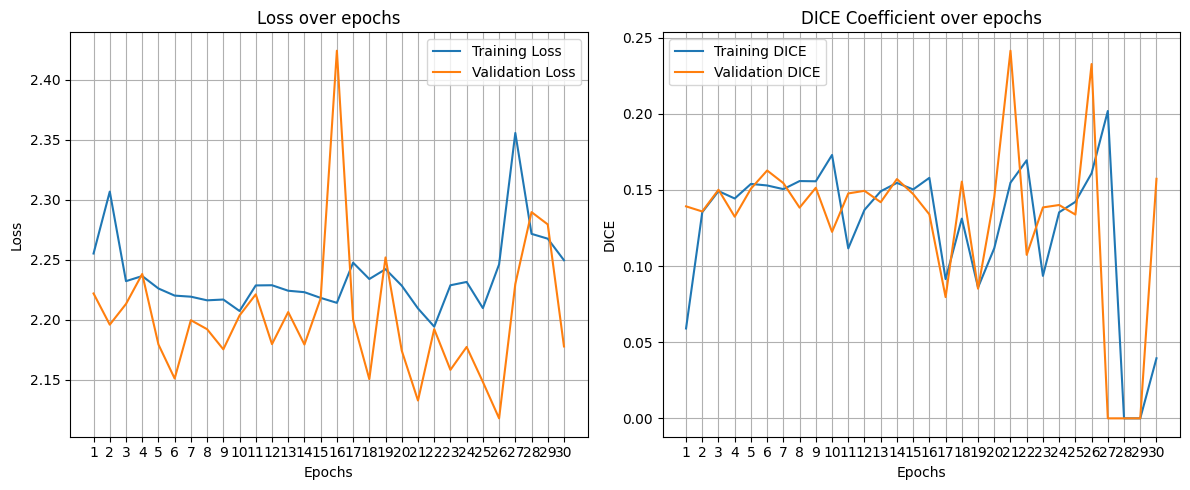

In [23]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_dcs, label='Training DICE')
plt.plot(epochs_list, val_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
def load(path=MODEL_PATH):
    m = UNet(in_channels=1, num_classes=1).to(device)
    m.load_state_dict(torch.load(path, map_location=torch.device(device)))
    return m

In [25]:
trained_model = load(MODEL_PATH)

In [26]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    i = 0
    for _, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = combined_loss(y_pred, mask)
        dc = dice(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()
        i += 1

    test_loss = test_running_loss / i
    test_dc = test_running_dc / i

print(f'Loss: {test_loss:.4f}, DICE: {test_dc:.4f}')

100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

Loss: 2.2197, DICE: 0.1783


In [24]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])
    mask_tensors.append(random_sample[1])
    image_paths.append(random_sample[2])

In [28]:
def random_images_inference(image_tensors, mask_tensors, image_paths, model_pth, device):
    model = UNet(in_channels=1, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    transform = transforms.Compose([
        transforms.Pad(padding=(0, 0, 1, 1)),  # left, top, right, bottom
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    ])

    # Iterate for the images, masks and paths
    for image_pth, mask_pth, image_paths in zip(image_tensors, mask_tensors, image_paths):
        # Load the image
        img = transform(image_pth)

        # Predict the imagen with the model
        pred_mask = model(img.unsqueeze(0))
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)

        # Load the mask to compare
        mask = transform(mask_pth).permute(1, 2, 0).to(device)

        print(f"Image: {os.path.basename(image_paths)}, DICE coefficient: {round(float(dice(pred_mask.detach(), mask.detach())),5)}")

        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1

        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("original")
        plt.subplot(132), plt.imshow(mask, cmap="gray"), plt.title("mask")
        plt.subplot(133), plt.imshow(pred_mask, cmap="gray"), plt.title("predicted")
        plt.show()

In [29]:
def random_images_inference_2(image_tensors, mask_tensors, image_paths, model_pth, device):
    """
    Show original images, ground truth masks, and model predictions.

    Args:
        image_tensors: list of torch tensors [C,H,W] or [1,H,W]
        mask_tensors: list of torch tensors [1,H,W]
        image_paths: list of image file paths (for titles)
        model_pth: path to saved model weights
        device: 'cuda' or 'cpu'
    """
    # Make sure model is instantiated
    model = UNet(in_channels=1, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=device))
    model.eval()

    n = len(image_tensors)
    plt.figure(figsize=(12, 4 * n))

    with torch.no_grad():
        for i in range(n):
            img = image_tensors[i].unsqueeze(0).float().to(device)  # [1,1,H,W]
            mask = mask_tensors[i].cpu().squeeze().numpy()           # [H,W]

            # Forward pass
            pred = model(img)
            pred_mask = torch.sigmoid(pred).cpu().squeeze().numpy()  # [H,W], probs

            # Threshold to binary mask
            pred_mask_bin = (pred_mask > 0.5).astype(float)

            # Original image for plotting
            orig_img = img.cpu().squeeze().numpy()  # [H,W]

            # Plot
            plt.subplot(n, 3, i * 3 + 1)
            plt.imshow(orig_img, cmap='gray')
            plt.title(f"Original\n{image_paths[i].split('/')[-1]}")
            plt.axis('off')

            plt.subplot(n, 3, i * 3 + 2)
            plt.imshow(mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(n, 3, i * 3 + 3)
            plt.imshow(pred_mask_bin, cmap='gray')
            plt.title(f"Predicted Mask\nDICE: {dice(torch.tensor(pred_mask_bin).unsqueeze(0),
                                        torch.tensor(mask).unsqueeze(0)):.4f}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()


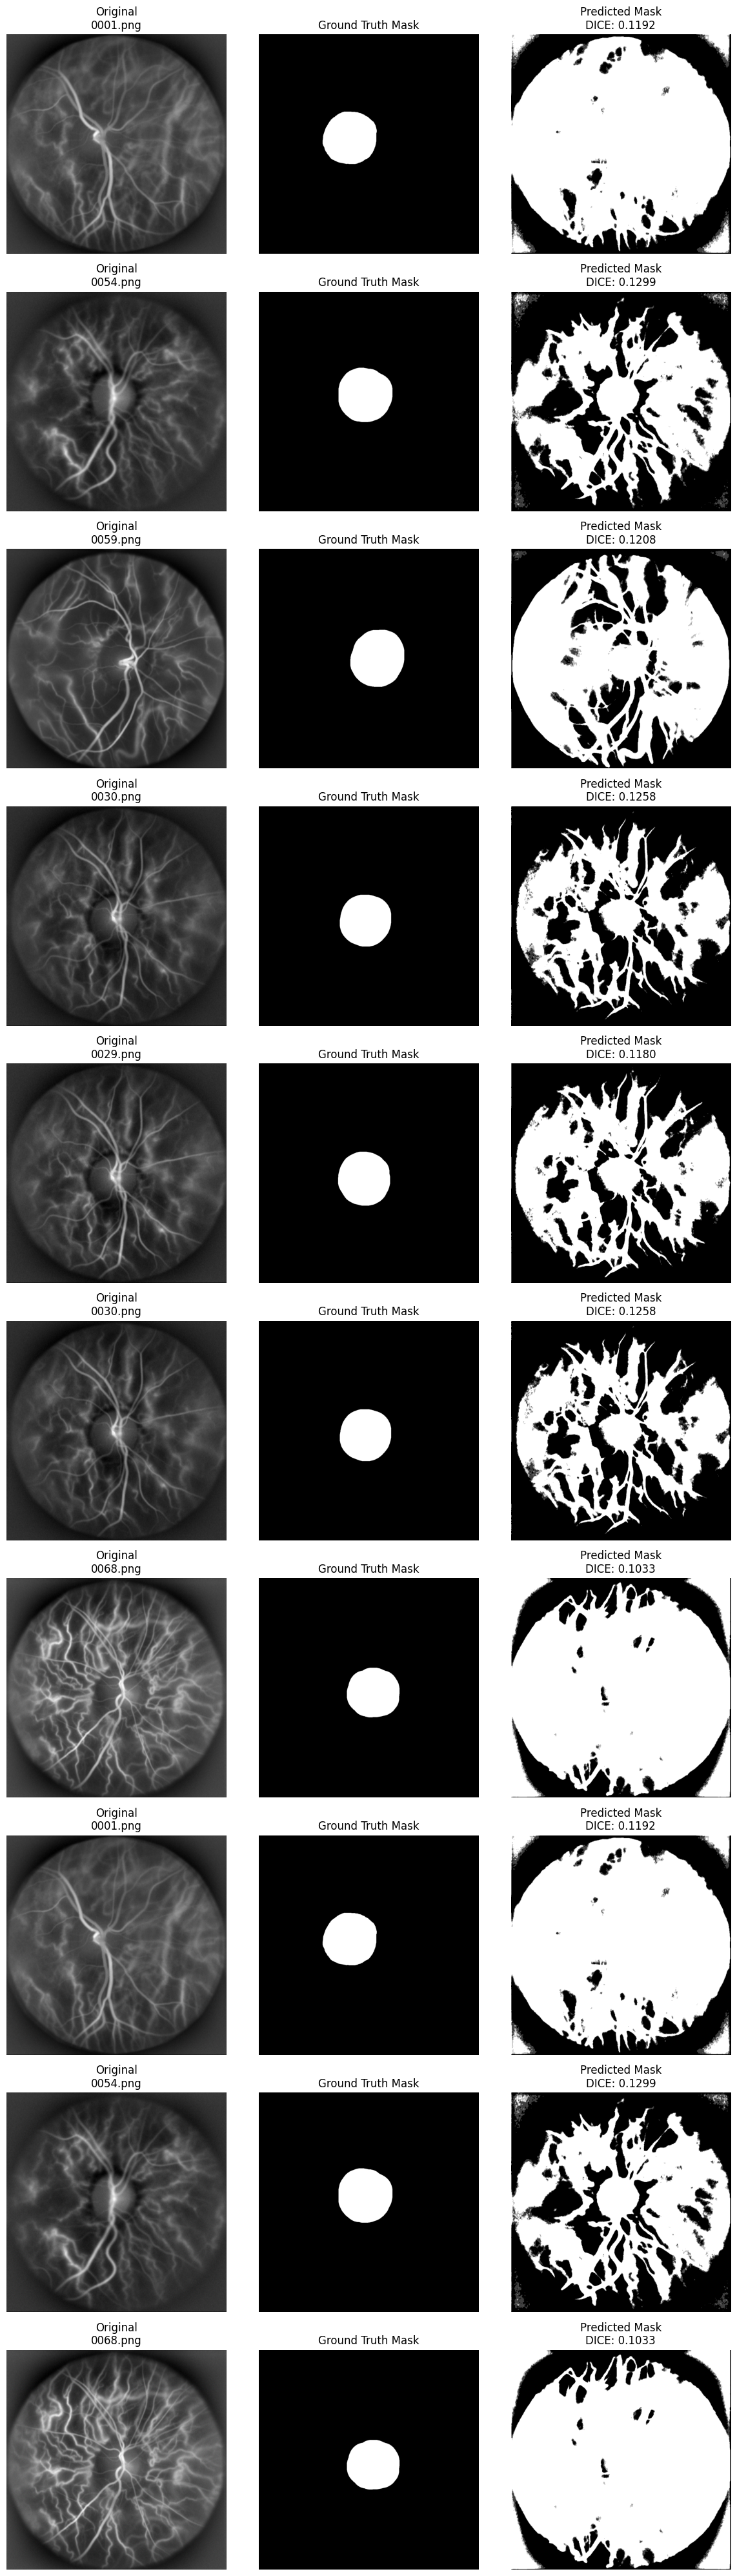

In [30]:
random_images_inference_2(image_tensors, mask_tensors, image_paths, MODEL_PATH, device="cuda")

In [89]:
mask = mask_tensors[0]
print("Mask min/max:", mask.min().item(), mask.max().item())
print("Foreground fraction:", mask.sum().item() / mask.numel())

Mask min/max: 0.0 1.0
Foreground fraction: 0.045271873474121094


## UResNet

### Model

In [12]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # To match dimensions for the skip connection if in/out channels differ
        self.shortcut = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
            if in_channels != out_channels else nn.Identity()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv(x)
        out += residual
        return self.relu(out)

In [13]:
class DownResSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownResSample, self).__init__()
        self.conv = ResBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        y = self.conv(x)
        p = self.pool(y)
        return y, p

In [14]:
class UpResSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpResSample, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ResBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x2 = self.up(x2)
        x = torch.cat([x1, x2], dim=1)
        return self.conv(x)

In [15]:
class UResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UResNet, self).__init__()
        self.down_conv1 = DownResSample(in_channels, 64)
        self.down_conv2 = DownResSample(64, 128)
        self.down_conv3 = DownResSample(128, 256)
        self.down_conv4 = DownResSample(256, 512)

        self.bottle_neck = ResBlock(512, 1024)

        self.up_conv1 = UpResSample(1024, 512)
        self.up_conv2 = UpResSample(512, 256)
        self.up_conv3 = UpResSample(256, 128)
        self.up_conv4 = UpResSample(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        s1, down1 = self.down_conv1(x)
        s2, down2 = self.down_conv2(down1)
        s3, down3 = self.down_conv3(down2)
        s4, down4 = self.down_conv4(down3)

        b = self.bottle_neck(down4)

        up1 = self.up_conv1(s4, b)
        up2 = self.up_conv2(s3, up1)
        up3 = self.up_conv3(s2, up2)
        up4 = self.up_conv4(s1, up3)

        return self.out(up4)

### Train

In [16]:
def train_uresnet(model, train_dataloader, val_dataloader, optimizer, combined_loss, dice,
                  device, epochs=20, save=True, path=MODEL_PATH):
    t_losses, t_dcs, v_losses, v_dcs = [], [], [], []

    scaler = GradScaler(device)
    best_val_dc = -1.0
    best_epoch = -1

    for epoch in range(epochs):
        # ---------------- TRAIN ----------------
        model.train()
        train_running_loss, train_running_dc = 0.0, 0.0

        for idx, (img, mask, _) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Train]")):
            img = img.float().to(device)      # [B,1,H,W]
            mask = mask.float().to(device)    # [B,1,H,W]

            optimizer.zero_grad()

            with autocast(device):
                y_pred = model(img)
                loss = combined_loss(y_pred, mask)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Dice for monitoring
            with torch.no_grad():
                dc = dice(y_pred, mask)

            train_running_loss += loss.item()
            train_running_dc += dc.item()

        train_loss = train_running_loss / (idx + 1)
        train_dc = train_running_dc / (idx + 1)
        t_losses.append(train_loss)
        t_dcs.append(train_dc)

        # ---------------- VALIDATION ----------------
        model.eval()
        val_running_loss, val_running_dc = 0.0, 0.0

        with torch.no_grad():
            for idx, (img, mask, _) in enumerate(tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Val]")):
                img = img.float().to(device)
                mask = mask.float().to(device)

                with autocast(device):
                    y_pred = model(img)
                    loss = combined_loss(y_pred, mask)

                dc = dice(y_pred, mask)

                val_running_loss += loss.item()
                val_running_dc += dc.item()

            val_loss = val_running_loss / (idx + 1)
            val_dc = val_running_dc / (idx + 1)
            v_losses.append(val_loss)
            v_dcs.append(val_dc)

        # ---------------- LOGGING ----------------
        print("-" * 40)
        print(f"Epoch {epoch+1}/{epochs}")
        print(f" Train Loss: {train_loss:.4f} | Train Dice: {train_dc:.4f}")
        print(f" Val Loss:   {val_loss:.4f} | Val Dice:   {val_dc:.4f}")
        print("-" * 40)

        # ---------------- CHECKPOINT ----------------
        if save and val_dc > best_val_dc:
            best_val_dc = val_dc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), path)
            print(f"✅ New best model saved at epoch {best_epoch} with Dice {best_val_dc:.4f}")

    # ---------------- LOAD BEST ----------------
    if save and best_epoch > 0:
        model.load_state_dict(torch.load(path, map_location=device))
        print(f"🎯 Loaded best model from epoch {best_epoch} (Dice {best_val_dc:.4f})")

    return t_losses, t_dcs, v_losses, v_dcs


In [17]:
model = UResNet(in_channels=1, num_classes=1).to(device)  # grayscale images
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

free_cache()
t_losses, t_dcs, v_losses, v_dcs = train_uresnet(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    combined_loss=combined_loss,
    dice=dice,
    device=device,
    epochs=20,
    save=True,
    path=MODEL_PATH
)
free_cache()

Epoch 1/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s]


----------------------------------------
Epoch 1/20
 Train Loss: 1.2874 | Train Dice: 0.5075
 Val Loss:   2.6624 | Val Dice:   0.3829
----------------------------------------
✅ New best model saved at epoch 1 with Dice 0.3829


Epoch 2/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


----------------------------------------
Epoch 2/20
 Train Loss: 0.7737 | Train Dice: 0.7256
 Val Loss:   0.7764 | Val Dice:   0.7545
----------------------------------------
✅ New best model saved at epoch 2 with Dice 0.7545


Epoch 3/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


----------------------------------------
Epoch 3/20
 Train Loss: 0.5923 | Train Dice: 0.7963
 Val Loss:   0.7236 | Val Dice:   0.7028
----------------------------------------


Epoch 4/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


----------------------------------------
Epoch 4/20
 Train Loss: 0.4559 | Train Dice: 0.8402
 Val Loss:   1.4594 | Val Dice:   0.6659
----------------------------------------


Epoch 5/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


----------------------------------------
Epoch 5/20
 Train Loss: 0.3665 | Train Dice: 0.8631
 Val Loss:   0.4326 | Val Dice:   0.8801
----------------------------------------
✅ New best model saved at epoch 5 with Dice 0.8801


Epoch 6/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


----------------------------------------
Epoch 6/20
 Train Loss: 0.3828 | Train Dice: 0.8548
 Val Loss:   1.4528 | Val Dice:   0.4432
----------------------------------------


Epoch 7/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


----------------------------------------
Epoch 7/20
 Train Loss: 0.3032 | Train Dice: 0.8805
 Val Loss:   1.1381 | Val Dice:   0.7496
----------------------------------------


Epoch 8/20 [Val]: 100%|██████████| 8/8 [00:03<00:00,  2.59it/s]


----------------------------------------
Epoch 8/20
 Train Loss: 0.2656 | Train Dice: 0.8903
 Val Loss:   0.4259 | Val Dice:   0.8362
----------------------------------------


Epoch 9/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.69it/s]


----------------------------------------
Epoch 9/20
 Train Loss: 0.2645 | Train Dice: 0.8955
 Val Loss:   0.4344 | Val Dice:   0.8853
----------------------------------------
✅ New best model saved at epoch 9 with Dice 0.8853


Epoch 10/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


----------------------------------------
Epoch 10/20
 Train Loss: 0.1969 | Train Dice: 0.9122
 Val Loss:   0.2612 | Val Dice:   0.9219
----------------------------------------
✅ New best model saved at epoch 10 with Dice 0.9219


Epoch 11/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


----------------------------------------
Epoch 11/20
 Train Loss: 0.2036 | Train Dice: 0.9095
 Val Loss:   0.2463 | Val Dice:   0.9011
----------------------------------------


Epoch 12/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


----------------------------------------
Epoch 12/20
 Train Loss: 0.1843 | Train Dice: 0.9150
 Val Loss:   0.2233 | Val Dice:   0.8974
----------------------------------------


Epoch 13/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


----------------------------------------
Epoch 13/20
 Train Loss: 0.1494 | Train Dice: 0.9274
 Val Loss:   0.2091 | Val Dice:   0.9315
----------------------------------------
✅ New best model saved at epoch 13 with Dice 0.9315


Epoch 14/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


----------------------------------------
Epoch 14/20
 Train Loss: 0.1729 | Train Dice: 0.9192
 Val Loss:   2.5382 | Val Dice:   0.6316
----------------------------------------


Epoch 15/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.87it/s]


----------------------------------------
Epoch 15/20
 Train Loss: 0.2007 | Train Dice: 0.9147
 Val Loss:   0.1917 | Val Dice:   0.9119
----------------------------------------


Epoch 16/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


----------------------------------------
Epoch 16/20
 Train Loss: 0.1532 | Train Dice: 0.9270
 Val Loss:   3.9787 | Val Dice:   0.5022
----------------------------------------


Epoch 17/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


----------------------------------------
Epoch 17/20
 Train Loss: 0.1902 | Train Dice: 0.9103
 Val Loss:   0.3651 | Val Dice:   0.9030
----------------------------------------


Epoch 18/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


----------------------------------------
Epoch 18/20
 Train Loss: 0.1658 | Train Dice: 0.9258
 Val Loss:   1.2060 | Val Dice:   0.7436
----------------------------------------


Epoch 19/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.89it/s]


----------------------------------------
Epoch 19/20
 Train Loss: 0.1565 | Train Dice: 0.9246
 Val Loss:   0.1918 | Val Dice:   0.9197
----------------------------------------


Epoch 20/20 [Val]: 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

----------------------------------------
Epoch 20/20
 Train Loss: 0.1121 | Train Dice: 0.9406
 Val Loss:   0.1905 | Val Dice:   0.9256
----------------------------------------
🎯 Loaded best model from epoch 13 (Dice 0.9315)


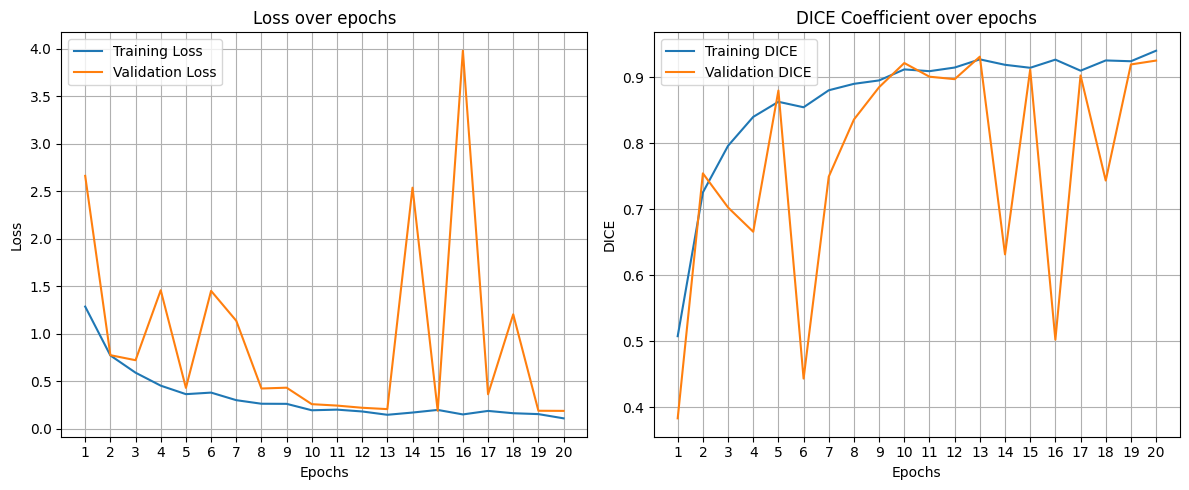

In [18]:
epochs_list = list(range(1, len(t_losses) + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, t_losses, label='Training Loss')
plt.plot(epochs_list, v_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, len(t_losses) + 1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()

plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_list, t_dcs, label='Training DICE')
plt.plot(epochs_list, v_dcs, label='Validation DICE')
plt.xticks(ticks=list(range(1, len(t_losses) + 1, 1)))
plt.title('DICE Coefficient over epochs')
plt.xlabel('Epochs')
plt.ylabel('DICE')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
def loadRes(path=MODEL_PATH):
    m = UResNet(in_channels=1, num_classes=1).to(device)
    m.load_state_dict(torch.load(path, map_location=torch.device(device)))
    return m

In [20]:
trained_model = loadRes(MODEL_PATH)

In [21]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    i = 0
    for _, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = combined_loss(y_pred, mask)
        dc = dice(y_pred, mask)

        test_running_loss += loss.item()
        test_running_dc += dc.item()
        i += 1

    test_loss = test_running_loss / i
    test_dc = test_running_dc / i

print(f'Loss: {test_loss:.4f}, DICE: {test_dc:.4f}')

100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

Loss: 0.1703, DICE: 0.9207


In [22]:
n = 10

image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]

    image_tensors.append(random_sample[0])
    mask_tensors.append(random_sample[1])
    image_paths.append(random_sample[2])

In [23]:
def res_random_images_inference(image_tensors, mask_tensors, image_paths, model_pth, device):
    """
    Show original images, ground truth masks, and model predictions.

    Args:
        image_tensors: list of torch tensors [C,H,W] or [1,H,W]
        mask_tensors: list of torch tensors [1,H,W]
        image_paths: list of image file paths (for titles)
        model_pth: path to saved model weights
        device: 'cuda' or 'cpu'
    """
    # Make sure model is instantiated
    model = UResNet(in_channels=1, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=device))
    model.eval()

    n = len(image_tensors)
    plt.figure(figsize=(12, 4 * n))

    with torch.no_grad():
        for i in range(n):
            img = image_tensors[i].unsqueeze(0).float().to(device)  # [1,1,H,W]
            mask = mask_tensors[i].cpu().squeeze().numpy()           # [H,W]

            # Forward pass
            pred = model(img)
            pred_mask = torch.sigmoid(pred).cpu().squeeze().numpy()  # [H,W], probs

            # Threshold to binary mask
            pred_mask_bin = (pred_mask > 0.5).astype(float)

            # Original image for plotting
            orig_img = img.cpu().squeeze().numpy()  # [H,W]

            # Plot
            plt.subplot(n, 3, i * 3 + 1)
            plt.imshow(orig_img, cmap='gray')
            plt.title(f"Original\n{image_paths[i].split('/')[-1]}")
            plt.axis('off')

            plt.subplot(n, 3, i * 3 + 2)
            plt.imshow(mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(n, 3, i * 3 + 3)
            plt.imshow(pred_mask_bin, cmap='gray')
            plt.title(f"Predicted Mask\nDICE: {dice(torch.tensor(pred_mask_bin).unsqueeze(0),
                                        torch.tensor(mask).unsqueeze(0)):.4f}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

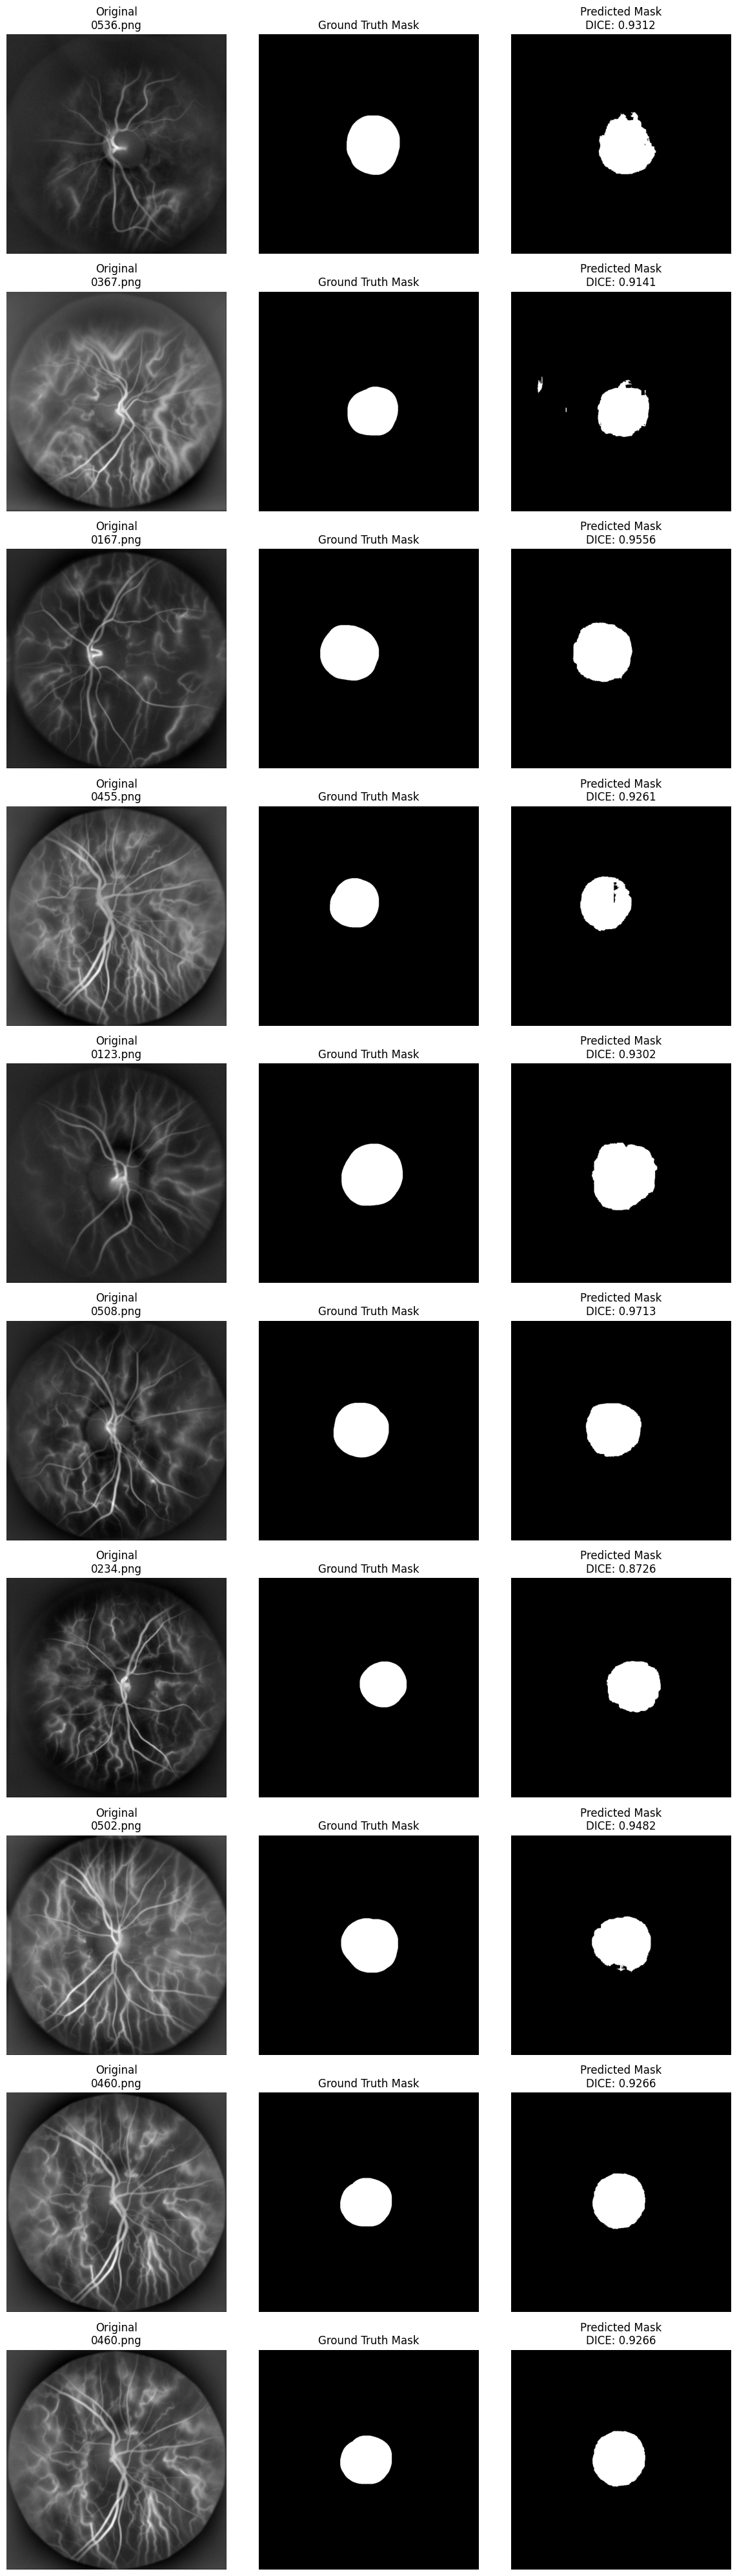

In [24]:
res_random_images_inference(image_tensors, mask_tensors, image_paths, MODEL_PATH, device)

In [25]:
def get_best_worst_samples(model, dataloaders, device, dice, n=10):
    """
    Evaluate model across multiple dataloaders (train, val, test, ...).
    Returns best/worst n samples globally based on Dice.

    Args:
        model: trained model
        dataloaders: list of dataloaders [train_dataloader, val_dataloader, test_dataloader]
        device: torch.device
        dice: function to compute dice score
        n: number of best/worst samples to return
    """
    model.eval()
    results = []  # will hold (dice_score, img, mask, path)

    with torch.no_grad():
        for loader in dataloaders:
            for img, mask, paths in tqdm(loader, desc="Evaluating"):
                img = img.float().to(device)
                mask = mask.float().to(device)

                y_pred = model(img)

                for b in range(img.size(0)):
                    dc_val = dice(y_pred[b:b+1], mask[b:b+1]).item()
                    results.append((dc_val, img[b].cpu(), mask[b].cpu(), paths[b]))

    # Sort by dice (ascending = worst first)
    results_sorted = sorted(results, key=lambda x: x[0])

    # Worst n
    worst_samples = results_sorted[:n]
    worst_image_tensors = [x[1] for x in worst_samples]
    worst_mask_tensors = [x[2] for x in worst_samples]
    worst_image_paths = [x[3] for x in worst_samples]

    # Best n
    best_samples = results_sorted[-n:][::-1]
    best_image_tensors = [x[1] for x in best_samples]
    best_mask_tensors = [x[2] for x in best_samples]
    best_image_paths = [x[3] for x in best_samples]

    return (
        worst_image_tensors,
        worst_mask_tensors,
        worst_image_paths,
        best_image_tensors,
        best_mask_tensors,
        best_image_paths,
    )

In [26]:
(
    worst_imgs,
    worst_masks,
    worst_paths,
    best_imgs,
    best_masks,
    best_paths,
) = get_best_worst_samples(trained_model,
                           [train_dataloader, val_dataloader, test_dataloader],
                           device,
                           dice,
                           n=10)

Evaluating: 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]


Worst samples paths:


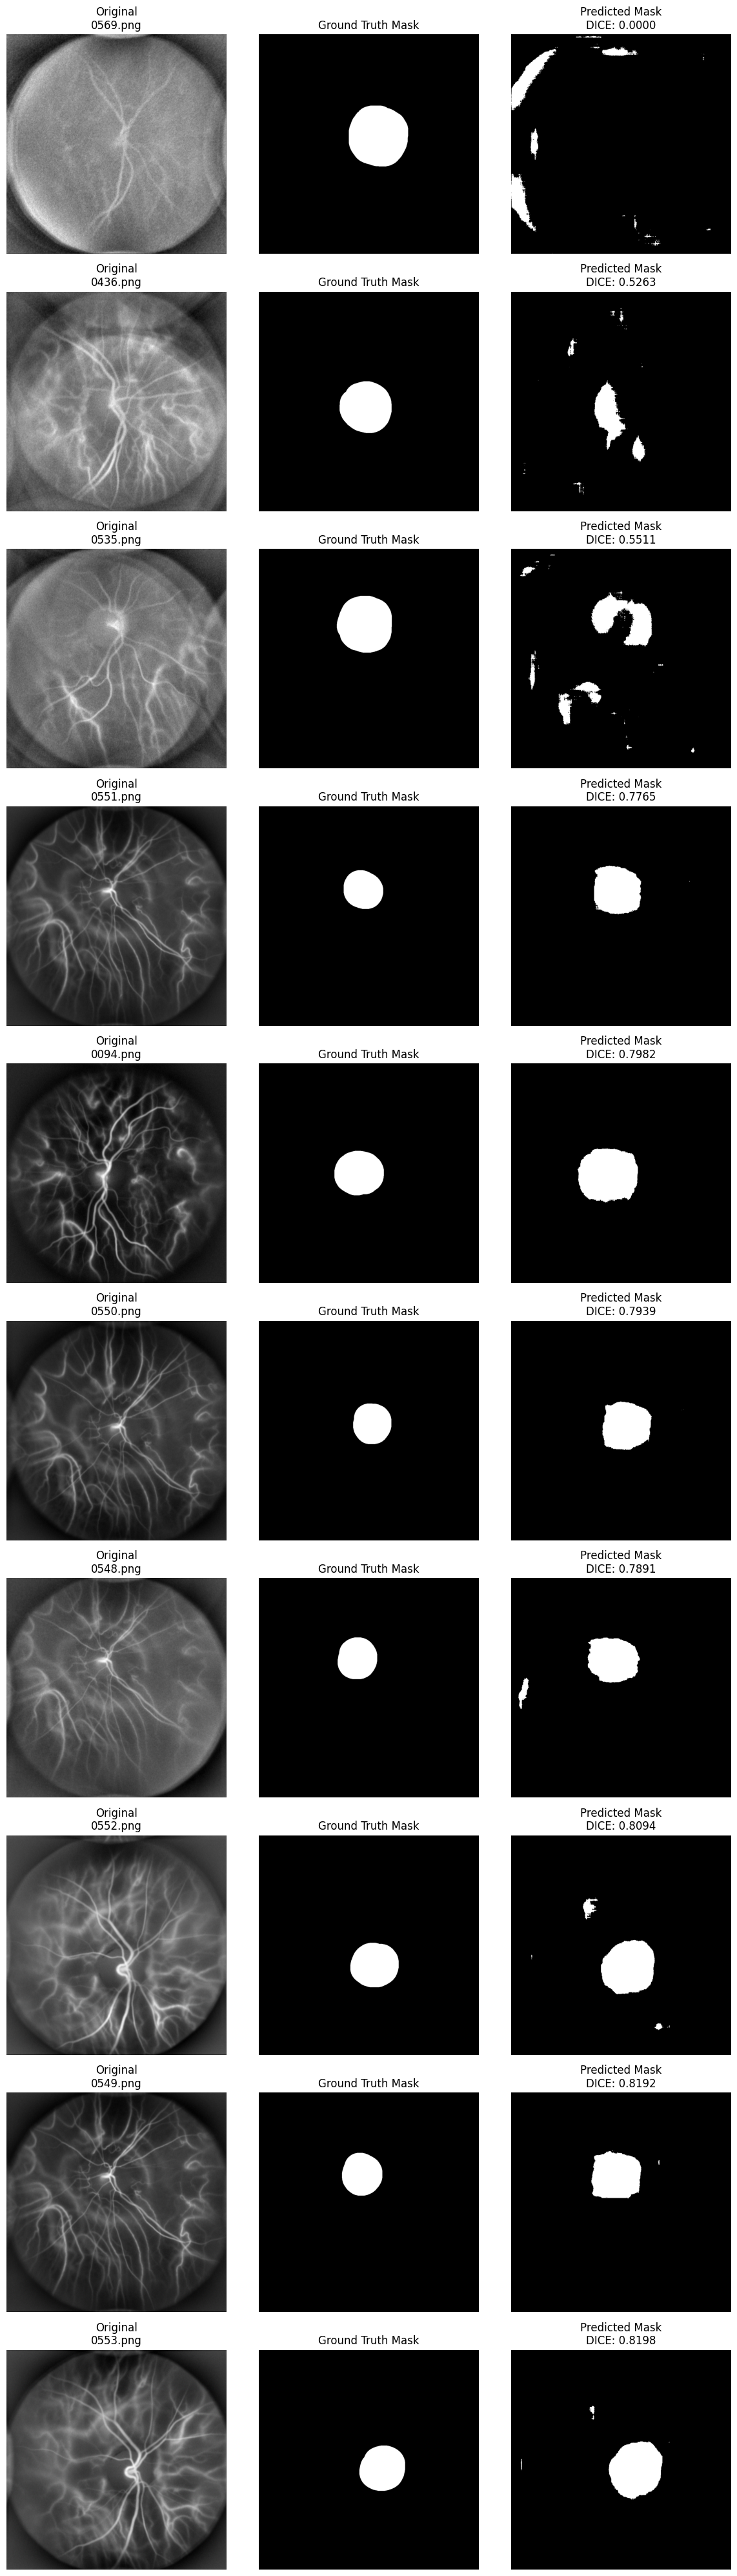

In [27]:
print("Worst samples paths:")
res_random_images_inference(worst_imgs, worst_masks, worst_paths, MODEL_PATH, device)

Best samples paths:


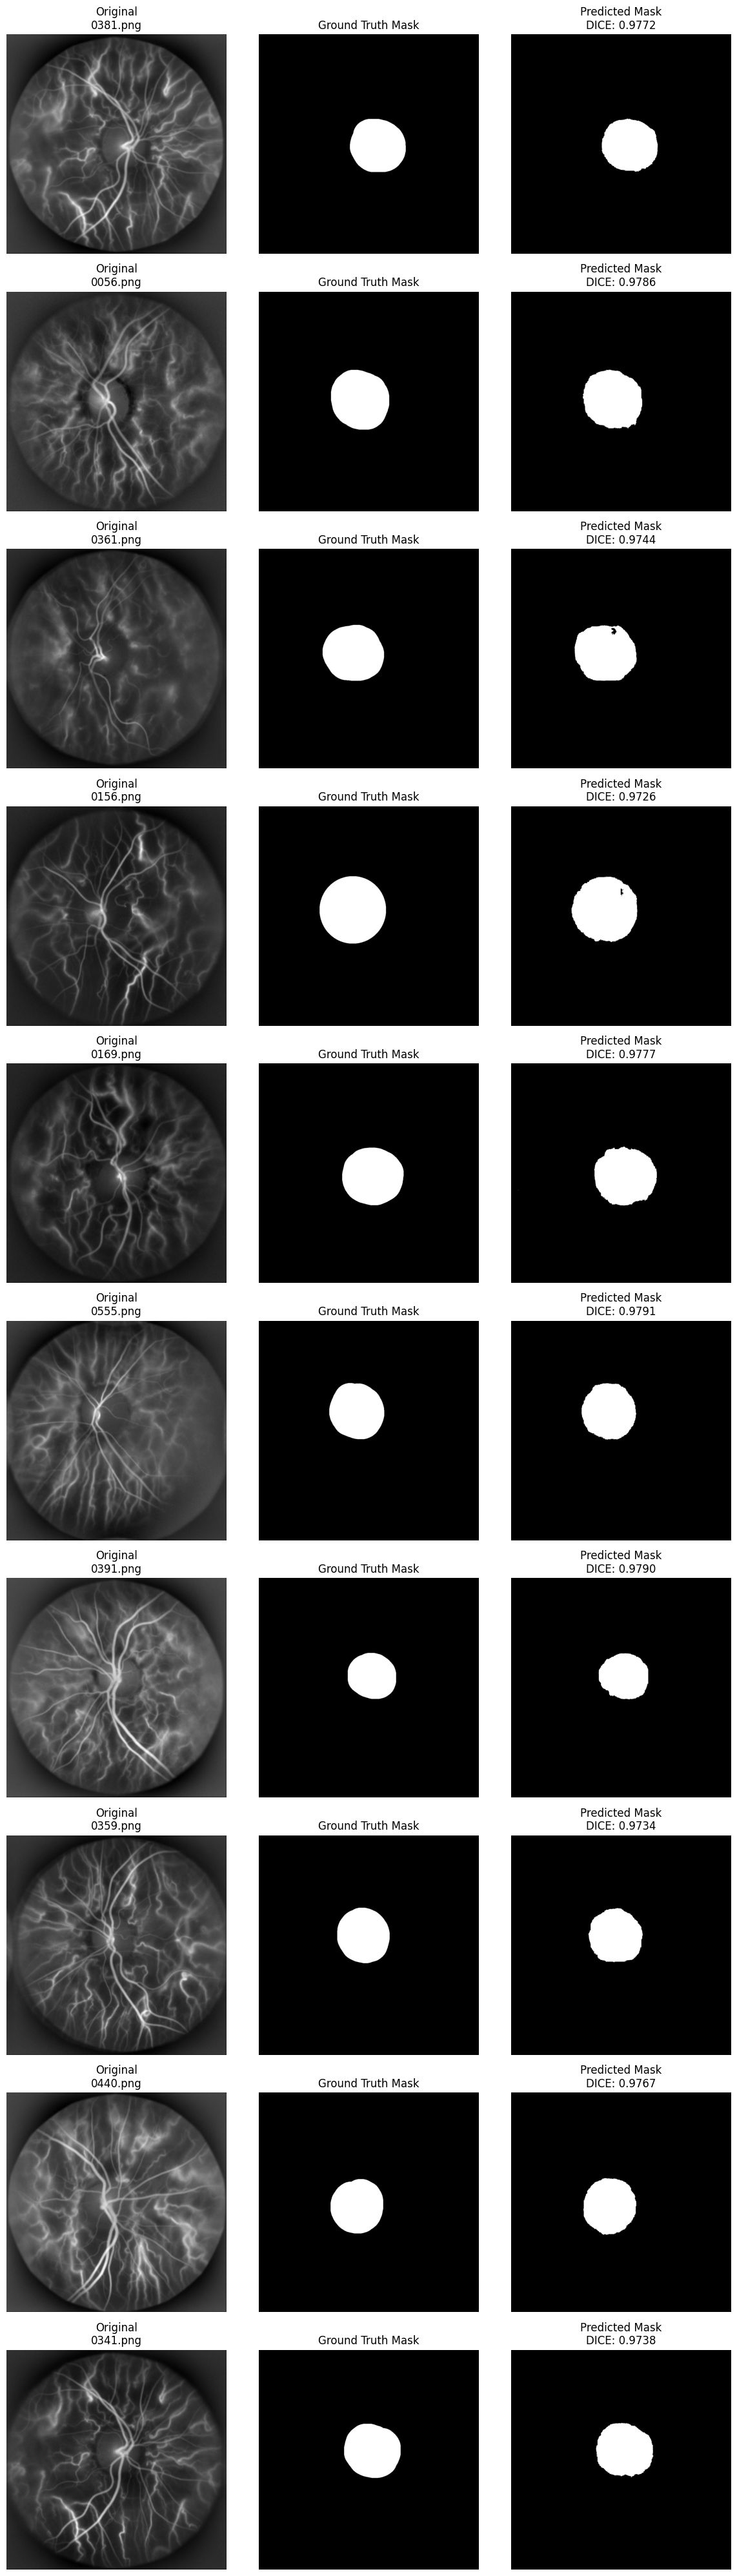

In [28]:
print("Best samples paths:")
res_random_images_inference(best_imgs, best_masks, best_paths, MODEL_PATH, device)

In [ ]:
edge_cases = [
    195,
    196,
    197,
    201,
    212,
    250,
    258,
    282,
    289,
    351,
    368,
    369,
    370,
    371,
    382,
    402,
    403,
    404,
    414,
    415,
    417,
    418,
    419,
    436,
    441,
    462,
    463,
    464,
    514,
    525,
    526,
    527,
    528,
    529,
    530,
    531,
    532,
    533,
    534,
    535,
    536,
    537,
    569,
    570,
    571,
    585,
    595,
    596,
    597,

]